# Filter & denoise

### Contents
0. Install packages
1. Denoising audio from scratch with the FFT and iFFT
2. Using the NoiseReduce package
3. Low-pass filter with scipy.signal (in progress)
4. Experiment with Noisereduce 
5. Filter audio with a low pass filter

## 0. Install packages

In [ ]:
# Install noisereduce. Uncomment if necessary
!pip install noisereduce

## 1. Denoising data with the FFT
source: https://www.youtube.com/watch?v=s2K1JfNR7Sc

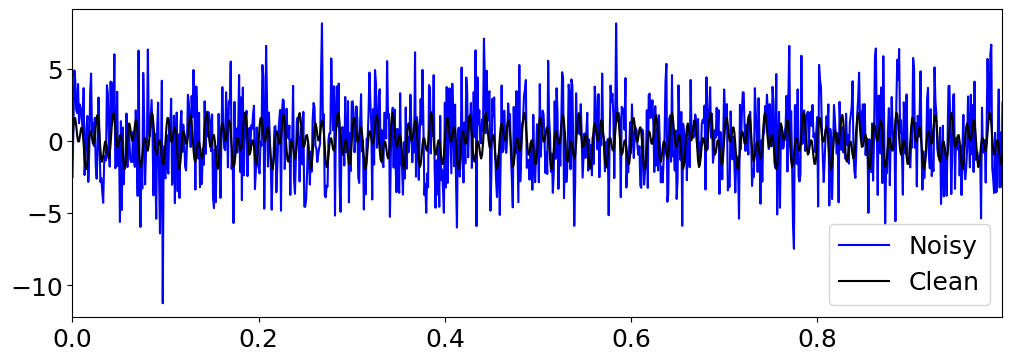

In [1]:

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']= [12,4]
plt.rcParams.update({'font.size': 18})

#Create a simple signal with two frequencies
dt = 0.001
t = np.arange(0,1,dt)
f = np.sin(2*np.pi*50*t) + np.sin(2* np.pi*120*t) #sum of 2 frequencies
f_clean = f
f = f + 2.5*np.random.randn(len(t)) #add some noise

plt.plot(t,f,color='b', label = 'Noisy') #check LineWidth
plt.plot(t, f_clean, color='k', label = 'Clean')
plt.xlim(t[0], t[-1])
plt.legend()

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


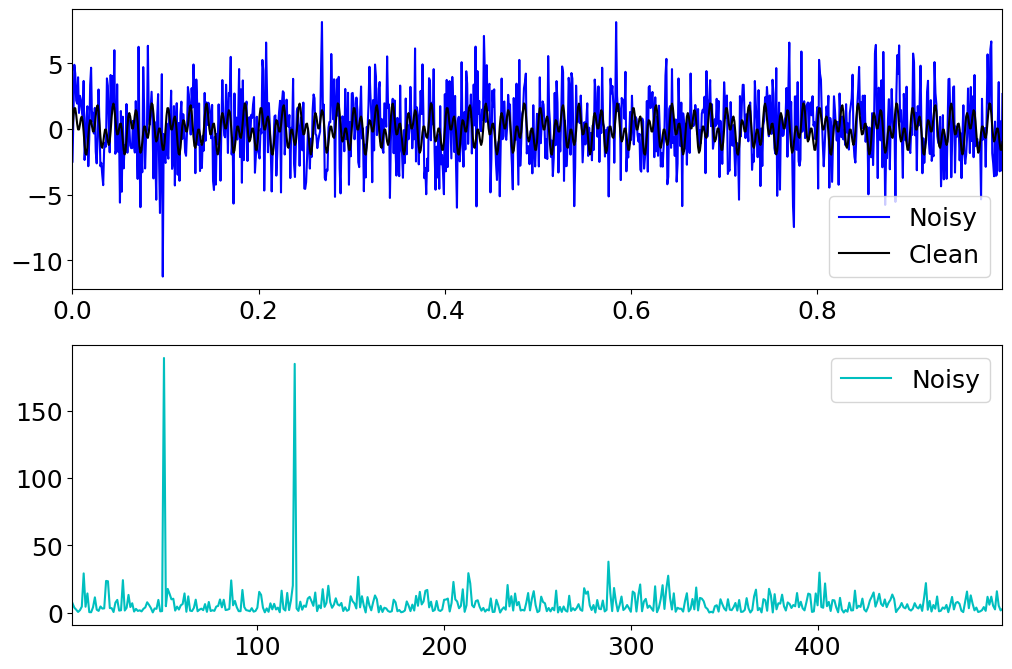

In [2]:
# computing the FFT
n = len(t)
fhat = np.fft.fft(f,n) # 
PSD = fhat *np.conj(fhat) /n #PSD = Power Spectral Density
freq = (1/(dt*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype = 'int')

plt.rcParams['figure.figsize']= [12,8]
fig, axs = plt.subplots(2,1)

plt.sca(axs[0])
plt.plot(t,f,color='b', label = 'Noisy') #check LineWidth
plt.plot(t, f_clean, color='k', label = 'Clean')
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(freq[L], PSD[L], color = 'c', label ='Noisy')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()

plt.show()

In [3]:
# create a filter at 100
# use the PSD to filter out the noise

indices = PSD > 100 #find all freqs with large power
PSDclean = PSD * 100 #zero all out others
fhat = indices * fhat
ffilt = np.fft.ifft(fhat)

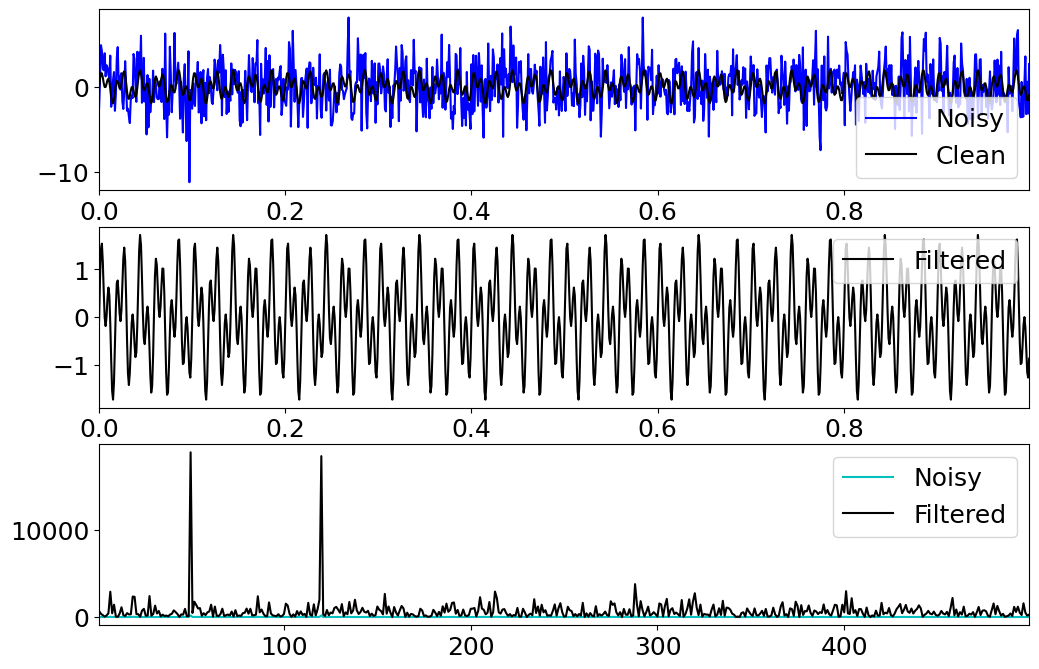

In [4]:
figs, axs = plt.subplots(3,1)

plt.sca(axs[0])
plt.plot(t,f,color='b', label = 'Noisy') #check LineWidth
plt.plot(t, f_clean, color='k', label = 'Clean')
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(t, ffilt, color='k', label='Filtered')
plt.xlim(t[0], t[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L], PSD[L], color='c', label = 'Noisy')
plt.plot(freq[L], PSDclean[L], color='k', label='Filtered')
plt.xlim(freq[L[0]], freq[L[-1]])
plt.legend()

plt.show()

## 2. Noisereduce


#### Steps of the Stationary Noise Reduction algorithm
1. A spectrogram is calculated over the noise audio clip
2. Statistics are calculated over spectrogram of the the noise (in frequency)
3. A threshold is calculated based upon the statistics of the noise (and the desired sensitivity of the algorithm)
4. A spectrogram is calculated over the signal
5. A mask is determined by comparing the signal spectrogram to the threshold
6. The mask is smoothed with a filter over frequency and time
7. The mask is appled to the spectrogram of the signal, and is inverted If the noise signal is not provided, the algorithm will treat the signal as the noise clip, which tends to work pretty well

sources: 

- Pypi: https://pypi.org/project/noisereduce
- GitHub: https://github.com/timsainb/noisereduce

In [5]:
from glob import glob
my_wavs = glob('*.wav')
print(my_wavs)

['new_file.wav', 'mywav_reduced_noise2.wav', 'recordedFile.wav', 'tone_220.wav', 'output_sine_wave.wav', 'tone_440.wav']


In [6]:
audio_data = my_wavs[1]

In [7]:
import IPython
IPython.display.Audio(audio_data)

In [8]:
#creating a waveplot
%matplotlib inline
import librosa
import matplotlib.pyplot as plt
import librosa.display
#audio_data = 'claxon_michiel.wav'
data , sr = librosa.load(audio_data) #sr = sampling rate
plt.figure(figsize=(20, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.5) # used to be: librosa.display.waveplot

In [9]:
#source: https://pypi.org/project/noisereduce/#:~:text=Noise%20reduction%20in%20python%20using,a%20form%20of%20Noise%20Gate.
from scipy.io import wavfile
import noisereduce as nr
# load data
librosa.to_mono(data) #convert to mono first
rate, data = wavfile.read(audio_data)
print(rate)
print(type(data))
print(len(data))

44100
<class 'numpy.ndarray'>
220160


In [10]:
# perform noise reduction
#librosa.to_mono(audio_data)
#data = np.reshape(data, (2, -1)) #source:https://stackoverflow.com/questions/70730921/noisereduce-algorithm-in-python-not-working
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("mywav_reduced_noise2.wav", rate, reduced_noise)

In [11]:
#creating a waveplot
%matplotlib inline
import librosa
import matplotlib.pyplot as plt
import librosa.display
#audio_data = my_wavs[3]
x , sr = librosa.load(my_wavs[1]) #sr = sampling rate
plt.figure(figsize=(20, 4))
librosa.display.waveshow(x, sr=sr) # used to be: librosa.display.waveplot

In [14]:
IPython.display.Audio("mywav_reduced_noise2.wav")

## 3. Filter audio with scipy.signal (in progress)
source: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

In [16]:
import numpy as np
from scipy.signal import butter, filtfilt
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [17]:
# sin wave
sig = np.sin(1.2*2*np.pi*T)
# Lets add some noise
noise = 1.5*np.cos(9*2*np.pi*T) + 0.5*np.sin(12.0*2*np.pi*T)
data = sig + noise

In [ ]:
# source

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

## 4. Experiment with Noise reduce

In [15]:
import glob
wavs_to_clean = glob.glob("./audio/*.wav")
wavs_to_clean

['./audio/0002c.wav',
 './audio/0003c.wav',
 './audio/0004c.wav',
 './audio/0000c.wav',
 './audio/0001c.wav']

In [22]:
import IPython

for i in range(len(wavs_to_clean)):
    print([wavs_to_clean[i]])
    IPython.display.Audio(wavs_to_clean[i])

['./audio/0002c.wav']
['./audio/0003c.wav']
['./audio/0004c.wav']
['./audio/0000c.wav']
['./audio/0001c.wav']


In [17]:
IPython.display.Audio(wavs_to_clean[0])

In [23]:
import numpy as np
import scipy.io.wavfile as wavfile

def calculate_snr(file_path):
    # Read the .wav file
    sample_rate, audio_data = wavfile.read(file_path)
    
    # Convert to float for calculations
    audio_float = audio_data.astype(float)
    
    # If stereo, convert to mono by averaging channels
    if audio_float.ndim > 1:
        audio_float = np.mean(audio_float, axis=1)
    
    # Normalize the audio data
    audio_norm = audio_float / np.max(np.abs(audio_float))
    
    # Calculate signal power
    signal_power = np.mean(audio_norm**2)
    
    # Estimate noise power (assuming first 1000 samples are noise)
    noise_power = np.mean(audio_norm[:1000]**2)
    
    # Calculate SNR
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

# Usage
for i in range(len(wavs_to_clean)):
    wav_file_path = wavs_to_clean[i]
    snr_value = calculate_snr(wav_file_path)
    print(f"Signal-to-Noise Ratio: {snr_value:.2f} dB")

Signal-to-Noise Ratio: -4.22 dB
Signal-to-Noise Ratio: 1.25 dB
Signal-to-Noise Ratio: 6.70 dB
Signal-to-Noise Ratio: 0.77 dB
Signal-to-Noise Ratio: -0.46 dB


In [26]:
from scipy.io import wavfile
import noisereduce as nr

for i in range(len(wavs_to_clean)):
    # Load the audio file
    rate, data = wavfile.read(wavs_to_clean[i])

    # Perform noise reduction
    reduced_noise = nr.reduce_noise(y=data, sr=rate)

    # Save the cleaned audio
    wavfile.write("reduced_noise_"+str(i)+".wav", rate, reduced_noise)


In [29]:
cleaned_wavs = glob.glob('./cleaned_audio/*.wav')
for i in range(len(cleaned_wavs)):
    wav_file_path = cleaned_wavs[i]
    snr_value = calculate_snr(wav_file_path)
    print(f"Signal-to-Noise Ratio: {snr_value:.2f} dB")

Signal-to-Noise Ratio: 0.20 dB
Signal-to-Noise Ratio: 4.29 dB
Signal-to-Noise Ratio: -8.97 dB
Signal-to-Noise Ratio: 7.56 dB
Signal-to-Noise Ratio: -6.51 dB


## 5. Filter audio with a low pass filter
source: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

In [1]:
import numpy as np
from scipy.signal import butter, filtfilt
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [2]:
# sin wave
sig = np.sin(1.2*2*np.pi*T)
# Lets add some noise
noise = 1.5*np.cos(9*2*np.pi*T) + 0.5*np.sin(12.0*2*np.pi*T)
data = sig + noise

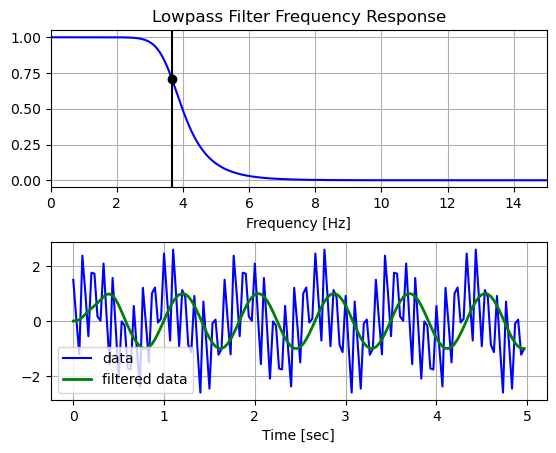

In [5]:
# source

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()